# Plot input variables

This script will help us make some nice plots that show the input variables for training

## Setup and Config

Modify the below things to change what things are plotted

In [14]:
# Designed not to be modified
import sys
sys.path.append("../")
from adl_func_client.event_dataset import EventDataset
from adl_func_client.use_exe_func_adl_server import use_exe_func_adl_server
from calratio_perjet_training.fetch_training_data import fetch_perjet_data
import glob
import numpy as np
import asyncio

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import rcParams
plt.rc('font', size=14)

import seaborn as sns
sns.set()

import pandas as pd

df_loc = "../data/datasets.csv"

## Load Datasets

In [2]:
datasets = pd.read_csv(df_loc)

In [3]:
async def fetch_data_async(info):
    return [info, f'{info.mH}_{info.mS}_{info.Lifetime}_{info.MCCampaign}', await fetch_perjet_data(EventDataset(f'localds://{info.RucioDSName}'), f'{info.mH}_{info.mS}_{info.Lifetime}_{info.MCCampaign}')]
all_datasets_future = [fetch_data_async(info) for index, info in datasets.iterrows()]
r = await asyncio.gather(*all_datasets_future)

This returns things in a funny format. So, some exploration. First, `r[i]` is the i'th dataset, and `r[i][0]` is the spects of that dataset:

In [4]:
r[0][0]

mH                                                            60
mS                                                             5
Lifetime                                                       5
MCCampaign                                                 mc16a
RucioDSName    mc16_13TeV.311417.MGPy8EG_A14NNPDF23_NNPDF31ME...
Name: 0, dtype: object

You can reference each of those items by attribute, for example `r[i][0].mH` to get the Higgs mass. `r[i][1]` is the name - which provides a clean way to label things:

In [5]:
r[0][1]

'60_5_5_mc16a'

And finally, the `pandas` dataframe for this sample is in `r[i][2]`:

In [6]:
r[0][2]

,RunNumber,EventNumber,JetPt,JetEta,JetPhi,IsLLP,nLLPs_Near_Jets,Lx,Ly,Lz,...,EH_CVL2,EH_TGL0,EH_TGL1,EH_TGL2,EH_EBL0,EH_EBL1,EH_EBL2,FC_L0,FC_L1,FC_L2
entry,,,,,,,,,,,,,,,,,,,,,
0,284500.0,2041602.0,50.151355,1.767030,0.074290,True,1,1851.684326,178.223892,5354.035156,...,0.000000,0.000000,0.000000,0.000000,0.019344,0.000731,0.000000,0.0,0.0,0.0
1,284500.0,2041537.0,45.315016,1.088594,0.364831,False,0,0.000000,0.000000,0.000000,...,-0.000409,0.007784,-0.000218,0.174103,0.006951,0.000300,0.000130,0.0,0.0,0.0
2,284500.0,2159562.0,163.244844,1.709549,2.769850,True,1,609.158691,239.010056,1741.357788,...,0.000000,0.000000,0.000000,0.000000,0.004981,-0.000061,0.000000,0.0,0.0,0.0
3,284500.0,2159562.0,147.121187,-0.237002,-0.393413,False,0,0.000000,0.000000,0.000000,...,-0.000283,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,284500.0,2159739.0,54.661199,-0.730161,-2.550338,False,0,0.000000,0.000000,0.000000,...,0.010581,0.000009,-0.000370,-0.002349,0.000000,0.000000,0.000000,0.0,0.0,0.0
5,284500.0,2159612.0,57.575508,-0.679230,1.705358,False,0,0.000000,0.000000,0.000000,...,0.002675,-0.000508,0.002794,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
6,284500.0,2041493.0,46.729578,-1.403121,-1.725780,True,1,122.027023,903.753418,1733.289429,...,0.000000,0.000000,0.000000,0.000401,0.039884,0.011312,-0.000262,0.0,0.0,0.0
7,284500.0,2159659.0,47.926785,-0.654504,2.130259,False,0,0.000000,0.000000,0.000000,...,0.007621,0.000000,0.001412,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
8,284500.0,2159659.0,47.010680,-0.627007,-0.930283,True,1,2115.701660,2620.996338,2361.141357,...,0.753350,0.001397,0.001884,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


## Make a single dataset

This will allow us to explore things using other tools more easily. But might break the memory model.

In [32]:
def add_col (df):
    'Given the dataset, return a modified pandas DF'
    ds = df[2]
    ds['mH']=df[0].mH
    ds['mS']=df[0].mS
    ds['ct']=df[0].Lifetime
    return ds
#what_to_combine = r[20:35]
what_to_combine=r
all_jets = pd.DataFrame(pd.concat([d[2] for d in what_to_combine], keys=[(d[0].mH, d[0].mS, d[0].Lifetime, f'{d[0].mH}/{d[0].mS}', d[0].MCCampaign) for d in what_to_combine], names=['mH', 'mS', 'Lifetime', 'mH_mS', 'MC']).to_records())

Add caculated columns to `all_jets`:

In [33]:
all_jets['Lxy'] = np.sqrt(all_jets.Lx*all_jets.Lx + all_jets.Ly*all_jets.Ly)

In [34]:
all_jets

,mH,mS,Lifetime,mH_mS,MC,entry,RunNumber,EventNumber,JetPt,JetEta,...,EH_TGL0,EH_TGL1,EH_TGL2,EH_EBL0,EH_EBL1,EH_EBL2,FC_L0,FC_L1,FC_L2,Lxy
0,60,5,5,60/5,mc16a,0,284500.0,2041602.0,50.151355,1.767030,...,0.000000,0.000000,0.000000,0.019344,0.000731,0.000000,0.0,0.0,0.0,1860.241543
1,60,5,5,60/5,mc16a,1,284500.0,2041537.0,45.315016,1.088594,...,0.007784,-0.000218,0.174103,0.006951,0.000300,0.000130,0.0,0.0,0.0,0.000000
2,60,5,5,60/5,mc16a,2,284500.0,2159562.0,163.244844,1.709549,...,0.000000,0.000000,0.000000,0.004981,-0.000061,0.000000,0.0,0.0,0.0,654.370016
3,60,5,5,60/5,mc16a,3,284500.0,2159562.0,147.121187,-0.237002,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
4,60,5,5,60/5,mc16a,4,284500.0,2159739.0,54.661199,-0.730161,...,0.000009,-0.000370,-0.002349,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
5,60,5,5,60/5,mc16a,5,284500.0,2159612.0,57.575508,-0.679230,...,-0.000508,0.002794,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
6,60,5,5,60/5,mc16a,6,284500.0,2041493.0,46.729578,-1.403121,...,0.000000,0.000000,0.000401,0.039884,0.011312,-0.000262,0.0,0.0,0.0,911.954404
7,60,5,5,60/5,mc16a,7,284500.0,2159659.0,47.926785,-0.654504,...,0.000000,0.001412,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
8,60,5,5,60/5,mc16a,8,284500.0,2159659.0,47.010680,-0.627007,...,0.001397,0.001884,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,3368.354987
9,60,5,5,60/5,mc16a,9,284500.0,2159064.0,59.273605,-0.498937,...,0.000271,0.007204,0.000000,0.000000,0.000000,0.000269,0.0,0.0,0.0,756.539254


In [35]:
all_jets.columns.values

array(['mH', 'mS', 'Lifetime', 'mH_mS', 'MC', 'entry', 'RunNumber',
       'EventNumber', 'JetPt', 'JetEta', 'JetPhi', 'IsLLP',
       'nLLPs_Near_Jets', 'Lx', 'Ly', 'Lz', 'Leta', 'Lphi', 'EMM_BL0',
       'EMM_BL1', 'EMM_BL2', 'EMM_BL3', 'EMM_EL0', 'EMM_EL1', 'EMM_EL2',
       'EMM_EL3', 'EH_EL0', 'EH_EL1', 'EH_EL2', 'EH_EL3', 'EH_CBL0',
       'EH_CBL1', 'EH_CVL2', 'EH_TGL0', 'EH_TGL1', 'EH_TGL2', 'EH_EBL0',
       'EH_EBL1', 'EH_EBL2', 'FC_L0', 'FC_L1', 'FC_L2', 'Lxy'],
      dtype=object)

Set the figure width to be the size of the number of samples with different mass sizes.

In [36]:
sample_fig_size = (len(all_jets.mH_mS.unique())*2, 4)
def set_fig_size():
    plt.gcf().set_size_inches(sample_fig_size)

## Standard Kinematic Plots

First, jet $p_T$ and $\eta$ of all samples to get a feel for what these samples look like in aggregate. Note the long tails we see, especially in the low $m_H$ plots.

Wall time: 8min 45s


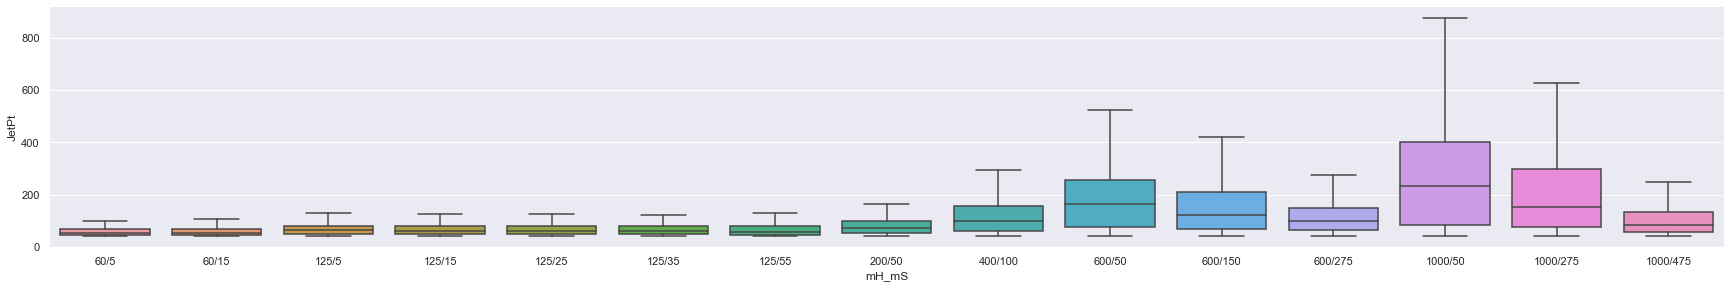

In [37]:
%%time
sns.catplot(x="mH_mS", y="JetPt", kind="box", data=all_jets, showfliers=False)
set_fig_size()

Wall time: 18min 58s


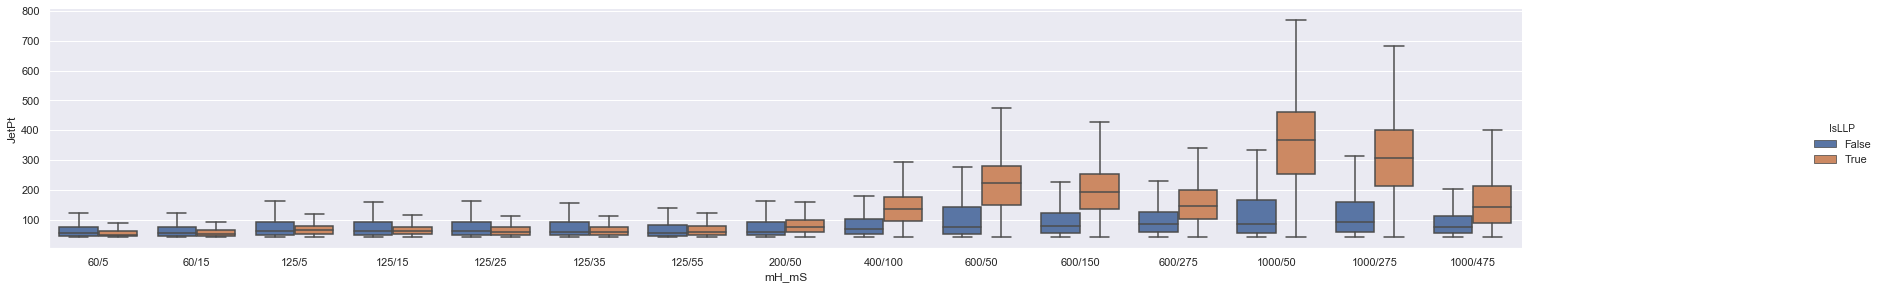

In [44]:
%%time
sns.catplot(x="mH_mS", y="JetPt", hue='IsLLP', kind="box", data=all_jets, showfliers=False)
set_fig_size()

Wall time: 12min 48s


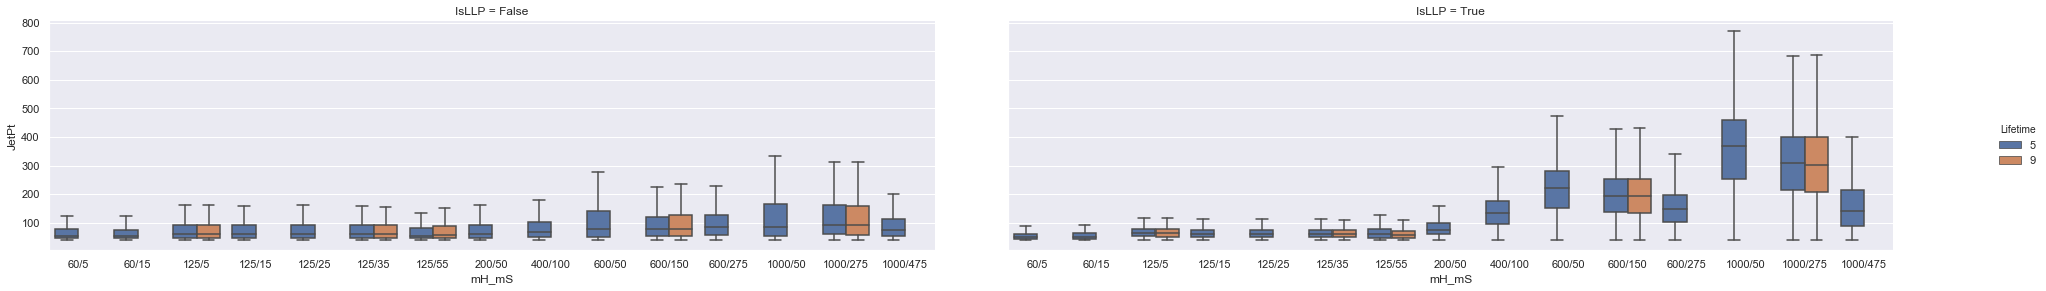

In [45]:
%%time
sns.catplot(x="mH_mS", y="JetPt", hue='Lifetime', col='IsLLP', kind="box", data=all_jets, showfliers=False)
set_fig_size()

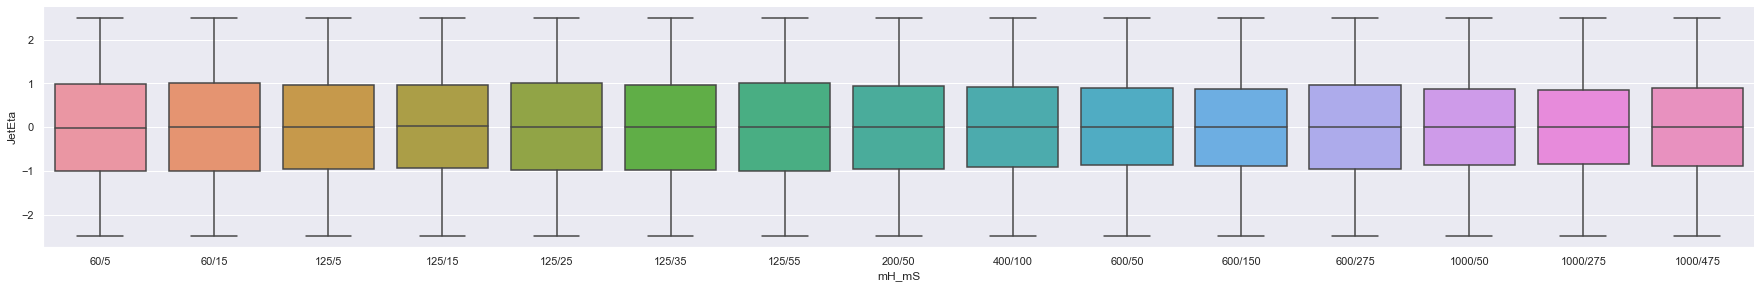

In [38]:
sns.catplot(x="mH_mS", y="JetEta", kind="box", data=all_jets)
set_fig_size()

## $L_{xy}$

How does the MC truth look in these various samples?

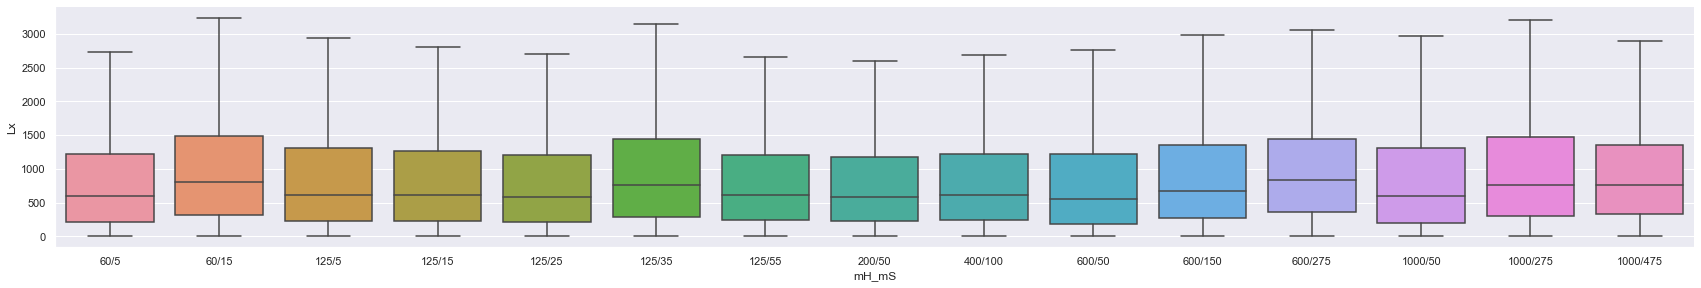

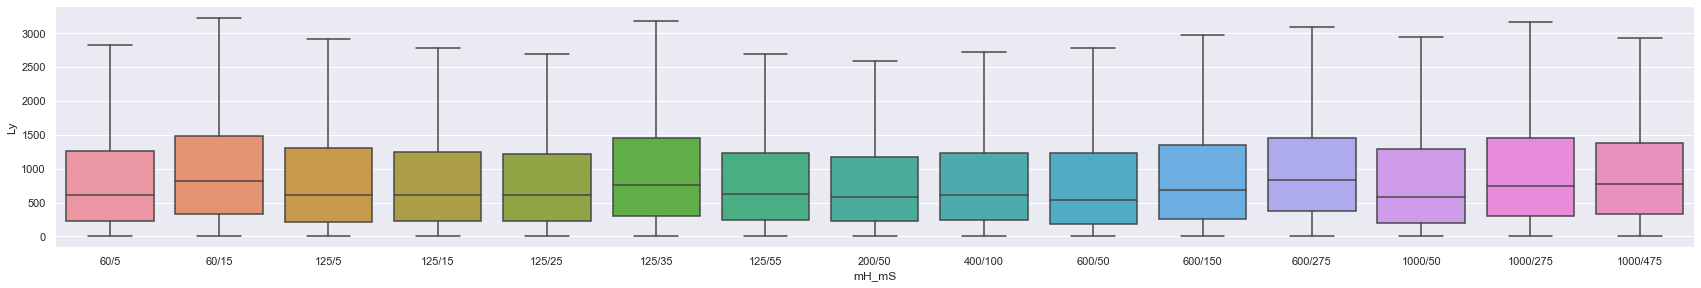

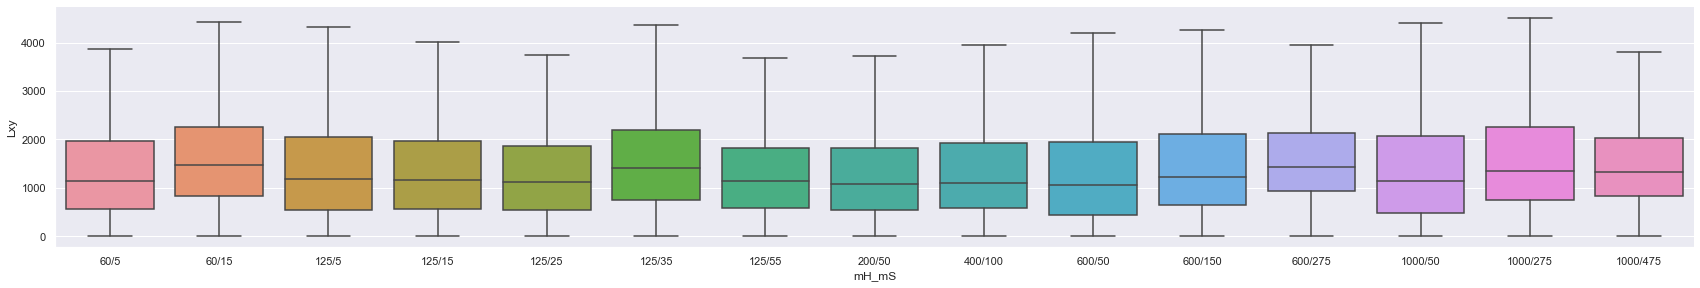

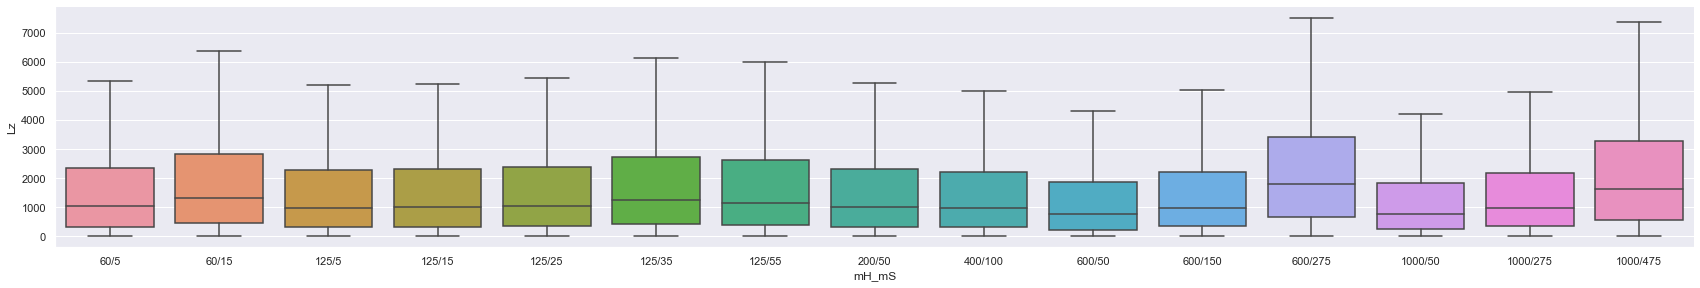

In [46]:
sns.catplot(x="mH_mS", y="Lx", kind="box", data=all_jets[all_jets.IsLLP], showfliers=False)
set_fig_size()
sns.catplot(x="mH_mS", y="Ly", kind="box", data=all_jets[all_jets.IsLLP], showfliers=False)
set_fig_size()
sns.catplot(x="mH_mS", y="Lxy", kind="box", data=all_jets[all_jets.IsLLP], showfliers=False)
set_fig_size()
sns.catplot(x="mH_mS", y="Lz", kind="box", data=all_jets[all_jets.IsLLP], showfliers=False)
set_fig_size()

And if we look at this as a function of lifetime there should be a clear difference.

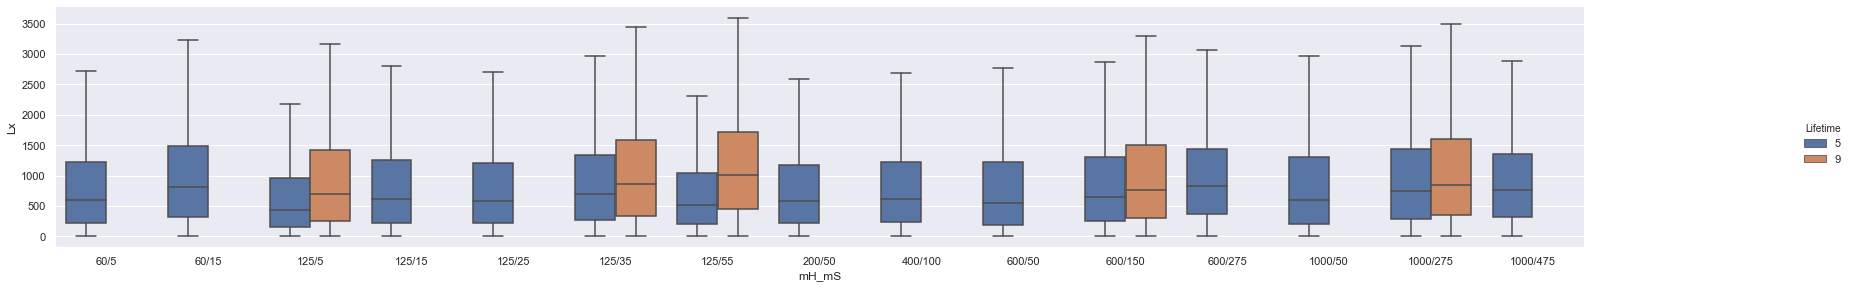

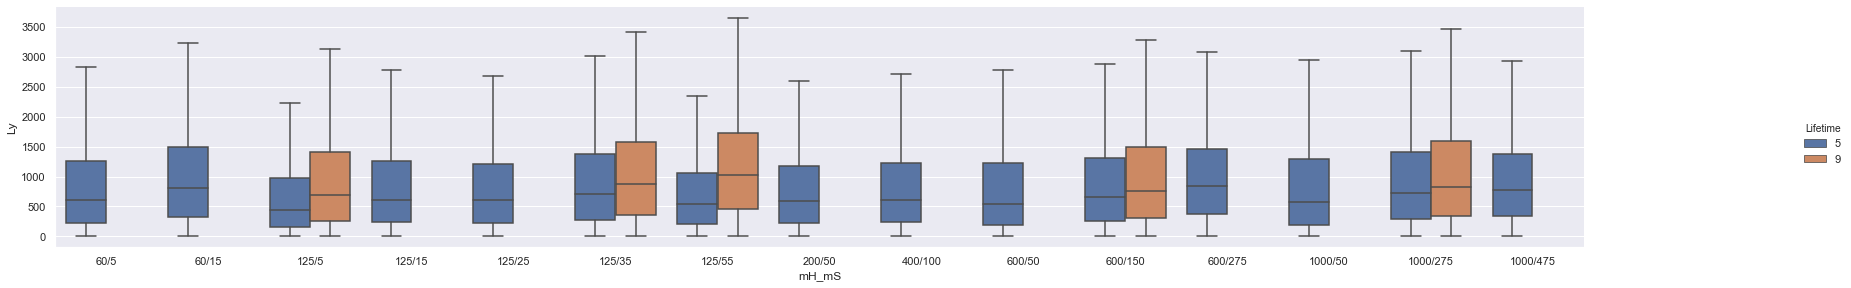

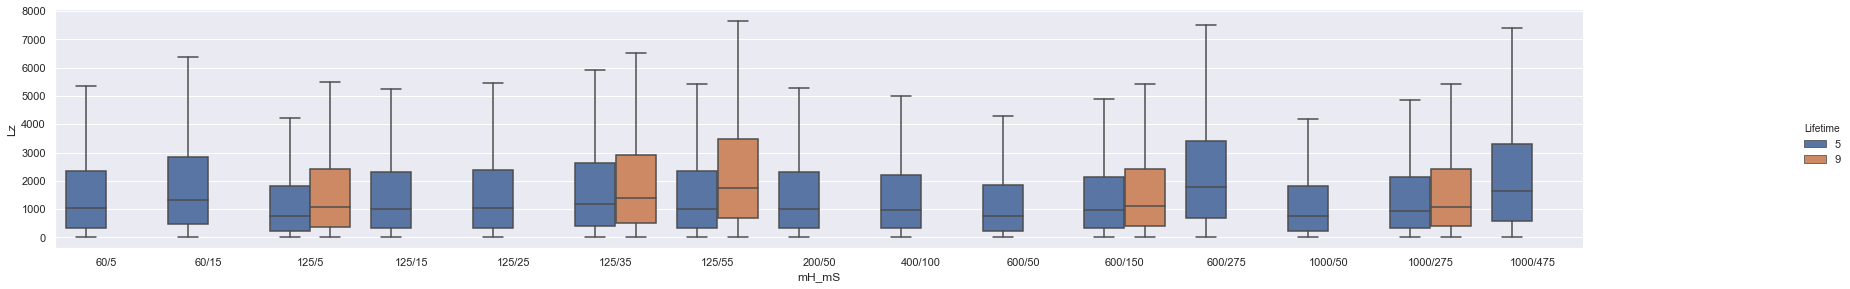

In [47]:
sns.catplot(x="mH_mS", y="Lx", hue='Lifetime', kind="box", data=all_jets[all_jets.IsLLP], showfliers=False)
set_fig_size()
sns.catplot(x="mH_mS", y="Ly", hue='Lifetime', kind="box", data=all_jets[all_jets.IsLLP], showfliers=False)
set_fig_size()
sns.catplot(x="mH_mS", y="Lz", hue='Lifetime', kind="box", data=all_jets[all_jets.IsLLP], showfliers=False)
set_fig_size()

I'd really like to make a plot of $m_H-2m_S$ and the $L_{xy}$, however the problem with that is that we don't have the actual lifetime here - just the lifetime in $c\tau$.

## MC Campaigns

We have different MC campaigns all mixed together. Is there any differences in these distributions? There shouldn't be any difference at the level we are working with here!

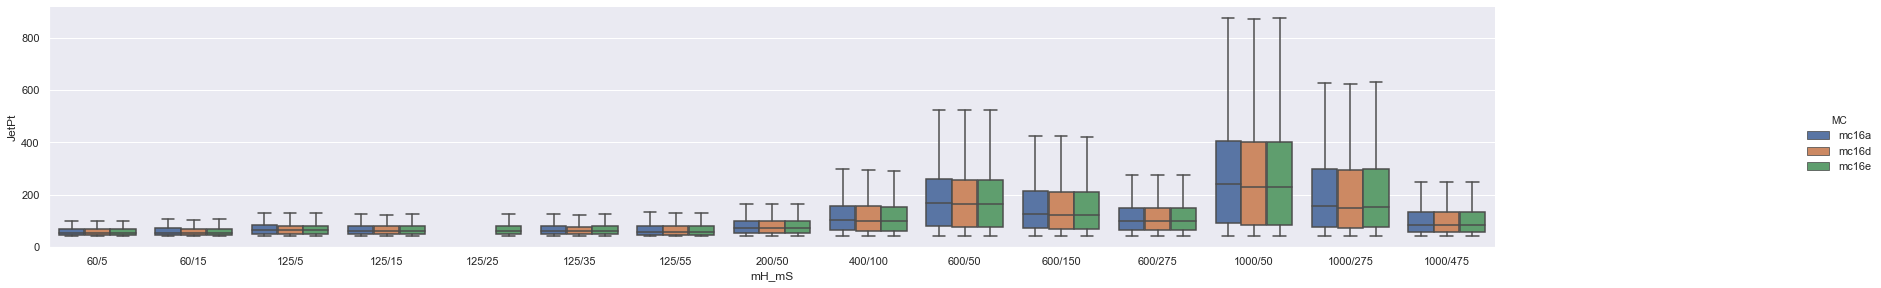

In [41]:
sns.catplot(x="mH_mS", y="JetPt", kind="box", hue="MC", data=all_jets, showfliers=False)
set_fig_size()

And the decay of the particles should not vary as a function of the campaign either!

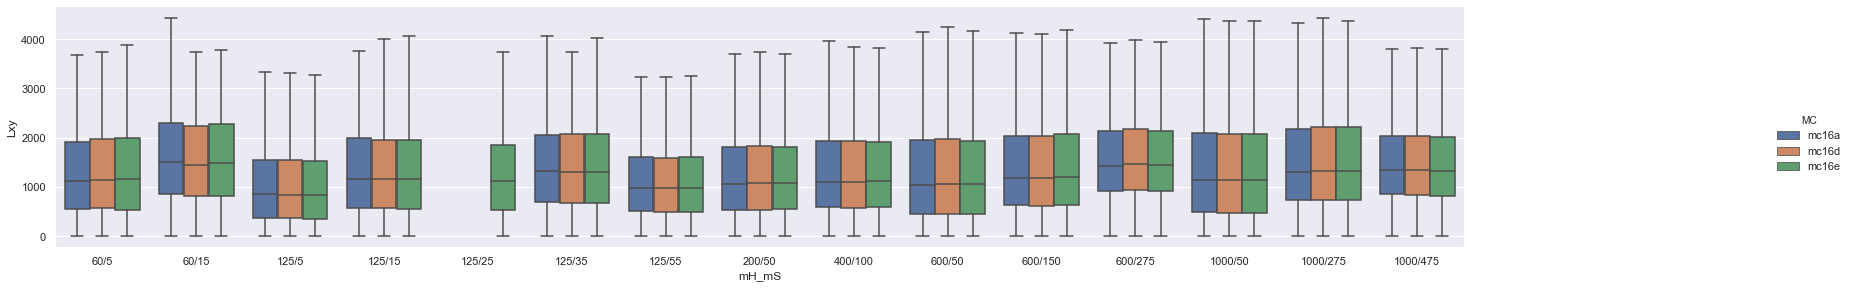

In [51]:
sns.catplot(x="mH_mS", y="Lxy", hue='MC', kind="box", data=all_jets[(all_jets.Lifetime==5) & (all_jets.IsLLP==1)], showfliers=False)
set_fig_size()

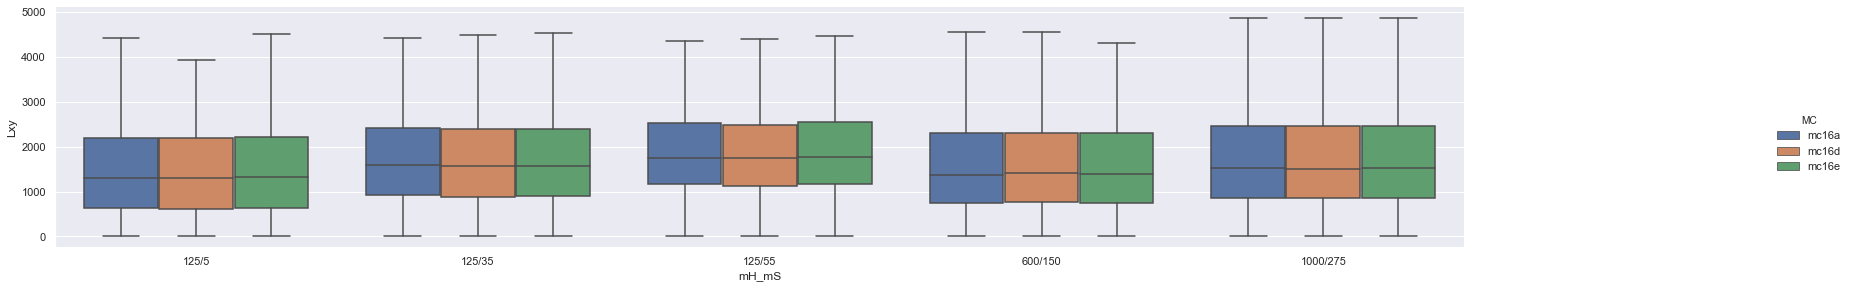

In [53]:
sns.catplot(x="mH_mS", y="Lxy", hue='MC', kind="box", data=all_jets[(all_jets.Lifetime==9)  & (all_jets.IsLLP==1)], showfliers=False)
set_fig_size()

## Long Lived Particle Truth

Look at the various truth variables that have come out

Lets look at how this varies as a function of $\eta$.

When Rachel looked at this, she recommended paying attention to $L_{zy}$ when $|\eta|<1.5$ and $L_z$ for $|\eta|>=1.5$. So, given we have the MC results here, lets look at how the distributions look as a function of jet $\eta$.

The funny shapes (or dips or cut-outs, depending on which two plots you are looking at) are explained by the angle w.r.t. the vertical, and how long in $L_z$ that line can be when it intersects with the outter barrel of the calorimeter. Where the behavior fundamentally changes (around $|\eta|=1.2$), is where the transition between the barrel and endcap or extended barrel occurs.

In [ ]:
plt.scatter(m125_m55_ltlow.JetEta, m125_m55_ltlow.Lz)
plt.ylabel('$L_z$ [mm]')
plt.xlabel('Jet $\eta$')
plt.ylim((0.0, 20000))
plt.plot((-1.2, -1.2), (0, 15000), color="black")
plt.plot((1.2, 1.2), (0, 15000), color="black")
_ = plt.show()

In [ ]:
plt.scatter(m125_m55_ltlow.JetEta, np.sqrt(np.square(m125_m55_ltlow.Lx)+np.square(m125_m55_ltlow.Ly)))
plt.ylabel('$L_{xy}$ [mm]')
plt.xlabel('Jet $\eta$')
plt.ylim((0.0, 20000))
plt.plot((-1.2, -1.2), (0, 15000), color="black")
plt.plot((1.2, 1.2), (0, 15000), color="black")
_ = plt.show()

## What are the large $R$ variables?

In the $L_xy$ vs $\eta$ plots above, there is a significant number of particles that have very large $L_zy$ (and $L_z$). I suspect those are LLP's that are randomly associated with jets. We can probably see this by looking at the $\Delta R$ between the LLP and the jet.

In [ ]:
Lx = m125_m55_ltlow.Lx[m125_m55_ltlow.IsLLP]
Ly = m125_m55_ltlow.Ly[m125_m55_ltlow.IsLLP]
Lxy = np.sqrt(np.square(Lx)+np.square(Ly))
Lz = m125_m55_ltlow.Lz[m125_m55_ltlow.IsLLP]
Leta = m125_m55_ltlow.Leta[m125_m55_ltlow.IsLLP]
Lphi = m125_m55_ltlow.Lphi[m125_m55_ltlow.IsLLP]

plt.hist(Lz, bins=40)
plt.title('m125_m55_ltlow')
plt.yscale('log')
plt.xlabel('$L_z$ [mm]')
plt.plot((7500, 7500), (0, 1e5), color="black")
plt.show()

plt.hist(Lxy, bins=40)
plt.title('m125_m55_ltlow')
plt.yscale('log')
plt.xlabel('$L_{xy}$ [mm]')
plt.plot((4400, 4400), (0, 1e5), color="black")
plt.show()

In [ ]:
too_far_lz = Lz > 7500
too_far_lxy = Lxy > 4400
print (f'outliers in Lxy: {sum(too_far_lxy)}, outliers in Lx: {sum(too_far_lz)}')

In [ ]:
plt.hist(Lz[too_far_lz], bins=40)
plt.title('m125_m55_ltlow - $L_z$ outliers')
plt.xlabel('$L_z$ [mm]')
plt.show()

plt.hist(Lxy[too_far_lz], bins=40)
plt.title('m125_m55_ltlow - $L_{xy}$ outliers')
plt.xlabel('$L_{xy}$ [mm]')
plt.show()

It took a few iterations to get $\Delta R$ calculated properly. There were bugs: ironically, not in the back-end, but in how I was coding up the request!

Here is proof that $\Delta R$ is getting correctly calculated

In [ ]:
JL_D_eta = m125_m55_ltlow.JetEta[m125_m55_ltlow.IsLLP] - Leta
JL_D_phi = m125_m55_ltlow.JetPhi[m125_m55_ltlow.IsLLP] - Lphi
while sum(JL_D_phi>=np.pi) > 0:
    JL_D_phi = JL_D_phi - (JL_D_phi>=np.pi)*2*np.pi
while sum(JL_D_phi<-np.pi) > 0:
    JL_D_phi = JL_D_phi + (JL_D_phi<-np.pi)*2*np.pi
JL_DeltaR = np.sqrt(np.square(JL_D_eta) + np.square(JL_D_phi))
plt.hist(JL_DeltaR, bins=40)
plt.show()

In [ ]:
bins = np.linspace(0.0, 0.4, 40)

plt.hist(JL_DeltaR, bins, label='all')
plt.hist(JL_DeltaR[too_far_lz], bins, label='outlier')
plt.yscale('log')
plt.xlabel('$\Delta R$')
plt.title('Outliers in $L_z$ ($L_z>7500$ mm)')
plt.legend()
plt.show()

plt.hist(JL_DeltaR, bins, label='all')
plt.hist(JL_DeltaR[too_far_lxy], bins, label='outlier')
plt.yscale('log')
plt.xlabel('$\Delta R$')
plt.title('Outliers in $L_{xy}$ ($L_{xy}>4400$ mm)')
plt.legend()
plt.show()

## MLP Input Variables

Look at the input variables for Lxy predictor

In [ ]:
plt.hist(m125_m55_ltlow.EMM_BL0, range=(0.0,1.0), bins=20)
plt.title('m125_m55_ltlow')
plt.yscale('log')
_ = plt.xlabel('EMM BL0 [Fraction]')